# Validate special case

In [1]:
#import all the things we need
%matplotlib inline
from qutip import*

from scipy import *
from scipy.integrate import solve_ivp

import QCLSolver.data as Data
import QCLSolver.solver as Solver
import QCLSolver.tool as Tool

import numpy as np

import matplotlib.pyplot as plt

In [2]:
def ConvertToSolver(t,y,data):
    data.SetCurrentValue(y.tolist())
    dy=np.asarray(data.Calculate())
    return dy

## Self-sustained oscillation in SHG

In [3]:
##parameters
delta_a=0
delta_b=0
kappa_a=2
kappa_b=2
FSR_enable=True
psi0_l=[0,0]
E=20; g=0.2

In [4]:
tlist=np.linspace(0,10,10000)

### QCLS

In [5]:
H=[['Aa',delta_a],['Bb',delta_b],['AAb',g],['aaB',g],['A',E],['a',E]] 
Co_ps=[['a',kappa_a],['b',kappa_b]]
T_o=['Aa','Bb','AAaa','BBbb']
order=4

In [6]:
data=Data.Data(H, Co_ps, T_o, order)

In [7]:
'''
initial=np.zeros(len(data.Calculate()),dtype=np.complex)
initial[0]=0.02
data.UpdateCoef(0,ForceUpdate=True)
sol_qcls=solve_ivp(ConvertToSolver,(0,tlist[-1]),initial,method='RK45',t_eval=tlist,args=(data,))
'''
len(data.Calculate())

37

In [8]:
sol_qcls=Solver.Solve(data,psi0_l,(0,10),t_eval=tlist)

### Mean-Feild

In [9]:
T_o=['a','b']

In [10]:
data_mean=Data.Data(H, Co_ps, T_o, 1)

In [11]:
initial=[0.1+0.1j,0]
#initial=[0j,0j]
data_mean.UpdateCoef(0,ForceUpdate=True)
sol_mean=solve_ivp(ConvertToSolver,(0,tlist[-1]),initial,method='RK45',t_eval=tlist,args=(data_mean,))

In [12]:
a_mean=np.average(np.real(sol_mean.y[0][5000:]*np.conj(sol_mean.y[0][5000:])))
b_mean=np.average(np.real(sol_mean.y[1][5000:]*np.conj(sol_mean.y[1][5000:])))

### Qutip

In [13]:
#helper function
def BuildOperator_SHG(E:float,g:float):
    Na=100; Nb=100
    psi0=tensor(basis(Na,psi0_l[0]),basis(Nb,psi0_l[1]))
    a=tensor(destroy(Na),qeye(Nb))
    b=tensor(qeye(Na),destroy(Nb))
    H=delta_a*a.dag()*a+delta_b*b.dag()*b+g*(b*a.dag()*a.dag()+b.dag()*a*a)\
        +E*(a.dag()+a)
    c_ops=[]
    c_ops.append(np.sqrt(kappa_a)*a)
    c_ops.append(np.sqrt(kappa_b)*b)
    operator={'Hamilton':H,'Collapse':c_ops,'Initial_state':psi0,'track':[a.dag()*a,b.dag()*b,\
                                                                          a.dag()*a.dag()*a*a,b.dag()*b.dag()*b*b]}
    return operator

In [14]:
op=BuildOperator_SHG(E,g)
output=mcsolve(op['Hamilton'],op['Initial_state'],tlist,op['Collapse'],op['track'],ntraj=2000)

10.0%. Run time: 9635.14s. Est. time left: 01:00:05:16
20.0%. Run time: 14212.36s. Est. time left: 00:15:47:29
30.0%. Run time: 18292.39s. Est. time left: 00:11:51:22
40.0%. Run time: 23819.77s. Est. time left: 00:09:55:29
50.0%. Run time: 28290.33s. Est. time left: 00:07:51:30
60.0%. Run time: 32707.96s. Est. time left: 00:06:03:25
70.0%. Run time: 37147.53s. Est. time left: 00:04:25:20
80.0%. Run time: 41573.79s. Est. time left: 00:02:53:13
90.0%. Run time: 46024.01s. Est. time left: 00:01:25:13
100.0%. Run time: 50104.32s. Est. time left: 00:00:00:00
Total run time: 50104.71s


### Visualize the result

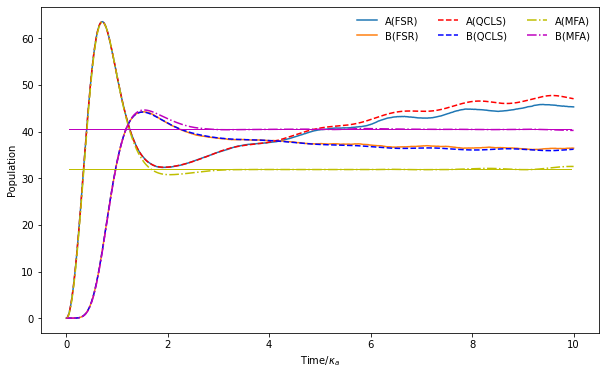

In [15]:
fig, axes = plt.subplots(1, 1, figsize=(10,6))

if (FSR_enable):
    axes.plot(tlist, output.expect[0],label="A(FSR)")
    axes.plot(tlist, output.expect[1],label="B(FSR)")

axes.plot(tlist, np.real(sol_qcls.y[0]),linestyle='--',color='red',label="A(QCLS)")
axes.plot(tlist, np.real(sol_qcls.y[1]),linestyle='--',color='blue',label="B(QCLS)")

axes.plot(tlist, np.real(sol_mean.y[0]*np.conj(sol_mean.y[0])),color='y',linestyle='-.',label="A(MFA)")
axes.plot(tlist, np.real(sol_mean.y[1]*np.conj(sol_mean.y[1])),color='m',linestyle='-.',label="B(MFA)")

axes.axhline(y=a_mean,xmin=0.05,xmax=0.95,linewidth=1,color='y')
axes.axhline(y=b_mean,xmin=0.05,xmax=0.95,linewidth=1,color='m')

axes.legend(loc=0,ncol=3,frameon=False)

axes.set_xlabel('Time/'+r'$\kappa_a$')
axes.set_ylabel('Population')

parameters='_E='+str(E)+'_g='+str(g)+'_kappa_a='+str(kappa_a)+'_kappa_b='+str(kappa_b)+'_order='+str(order)

fig.savefig('imgs_validate/SHG_c'+parameters+'.svg',dpi=600,format='svg')

In [16]:
print('g_2='+str(output.expect[2][-1]/(output.expect[0][-1]**2))+','+str(output.expect[3][-1]/(output.expect[1][-1]**2)))

g_2=1.0620346028418182,1.0011162670984528


In [17]:
print('g_2='+str(sol_qcls.y[2][-1]/(sol_qcls.y[0][-1]**2))+','+str(sol_qcls.y[3][-1]/(sol_qcls.y[1][-1]**2)))

g_2=(1.0452861392384027+0j),(1.0134240273395354+0j)


In [18]:
print(output.expect[0][-1],output.expect[1][-1])

45.28004927849097 36.43049104556413


## g2 in OPO

In [119]:
##parameters
kappa_a=2
kappa_b=4
FSR_enable=True
psi0_l=[0,0]
E=4; g=0.01

In [120]:
tlist=np.linspace(0,10,10000)

### QCLS

In [121]:
H=[['AAb',g],['aaB',g],['B',E],['b',E]] 
Co_ps=[['a',kappa_a],['b',kappa_b]]
#T_o=['Aa','Bb','AAaa','BBbb']
T_o=['Aa','Bb','A','AA','B','BB']
order=4

In [122]:
data=Data.Data(H, Co_ps, T_o, order)

In [123]:
initial=np.zeros(len(data.Calculate()),dtype=np.complex)
initial[2]=0.1j
initial[0]=0.01
data.UpdateCoef(0,ForceUpdate=True)
sol_qcls=solve_ivp(ConvertToSolver,(0,tlist[-1]),initial,method='RK45',t_eval=tlist,args=(data,))#
#sol_qcls=Solver.Solve(data,psi0_l,(0,10),t_eval=tlist)
g2_a=sol_qcls.y[3]*np.conj(sol_qcls.y[3])+2*(sol_qcls.y[0]**2-(sol_qcls.y[2]**2)*(np.conj(sol_qcls.y[2])**2))
g2_a=g2_a/(sol_qcls.y[0]**2)
g2_b=sol_qcls.y[5]*np.conj(sol_qcls.y[5])+2*(sol_qcls.y[1]**2-(sol_qcls.y[4]**2)*(np.conj(sol_qcls.y[4])**2))
g2_b=g2_b/(sol_qcls.y[1]**2)

C:\ProgramData\Anaconda3\envs\qutip\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


### Mean-Feild

In [124]:
T_o=['a','b']

In [125]:
data_mean=Data.Data(H, Co_ps, T_o, 1)

In [126]:
initial=[0.1j,0]
#initial=[0j,0j]
data_mean.UpdateCoef(0,ForceUpdate=True)
sol_mean=solve_ivp(ConvertToSolver,(0,tlist[-1]),initial,method='RK45',t_eval=tlist,args=(data_mean,))

### QuTip

In [127]:
#helper function
def BuildOperator_OPO(E:float,g:float):
    Nb=16; Na=10
    psi0=tensor(basis(Na,0)+0.1j*basis(Na,1),basis(Nb,psi0_l[1]))
    a=tensor(destroy(Na),qeye(Nb))
    b=tensor(qeye(Na),destroy(Nb))
    H=g*(b*a.dag()*a.dag()+b.dag()*a*a)+E*(b.dag()+b)
    c_ops=[]
    c_ops.append(np.sqrt(kappa_a)*a)
    c_ops.append(np.sqrt(kappa_b)*b)
    operator={'Hamilton':H,'Collapse':c_ops,'Initial_state':psi0,'track':[a.dag()*a,b.dag()*b,a.dag()*a.dag()*a*a,b.dag()*b.dag()*b*b,a]}
    return operator

In [128]:
op=BuildOperator_OPO(E,g)
output=mesolve(op['Hamilton'],op['Initial_state'],tlist,op['Collapse'],op['track'])
#output=mcsolve(op['Hamilton'],op['Initial_state'],tlist,op['Collapse'],op['track'],ntraj=1000)

### Visualize the result

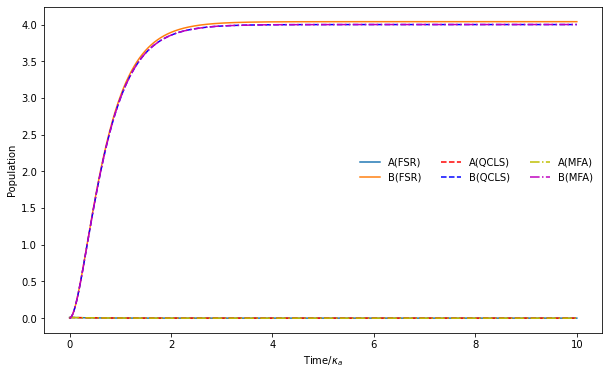

In [129]:
fig, axes = plt.subplots(1, 1, figsize=(10,6))

if (FSR_enable):
    axes.plot(tlist, output.expect[0],label="A(FSR)")
    axes.plot(tlist, output.expect[1],label="B(FSR)")

axes.plot(tlist, np.real(sol_qcls.y[0]),linestyle='--',color='red',label="A(QCLS)")
axes.plot(tlist, np.real(sol_qcls.y[1]),linestyle='--',color='blue',label="B(QCLS)")

axes.plot(tlist, np.real(sol_mean.y[0]*np.conj(sol_mean.y[0])),color='y',linestyle='-.',label="A(MFA)")
axes.plot(tlist, np.real(sol_mean.y[1]*np.conj(sol_mean.y[1])),color='m',linestyle='-.',label="B(MFA)")

axes.legend(loc=0,ncol=3,frameon=False)

axes.set_xlabel('Time/'+r'$\kappa_a$')
axes.set_ylabel('Population')

parameters='_E='+str(E)+'_g='+str(g)+'_kappa_a='+str(kappa_a)+'_kappa_b='+str(kappa_b)+'_order='+str(order)

fig.savefig('imgs_validate/OPO_c'+parameters+'.svg',dpi=600,format='svg')

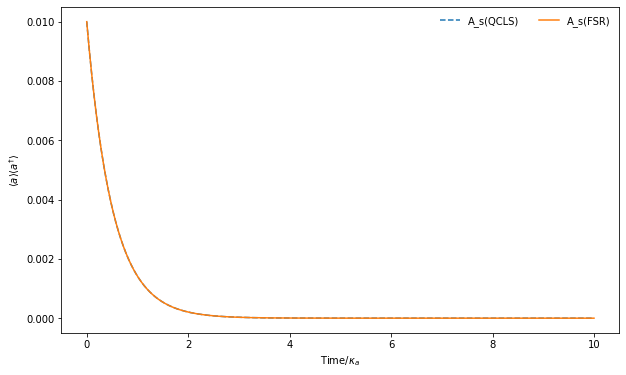

In [130]:
fig, axes = plt.subplots(1, 1, figsize=(10,6))


axes.plot(tlist, np.real(sol_qcls.y[2]*np.conj(sol_qcls.y[2])),linestyle='--',label="A_s(QCLS)")
axes.plot(tlist, np.real(output.expect[4]*np.conj(output.expect[4])),linestyle='-',label="A_s(FSR)")

axes.legend(loc=0,ncol=3,frameon=False)

axes.set_xlabel('Time/'+r'$\kappa_a$')
axes.set_ylabel(r'$\langle a\rangle\langle a^\dag\rangle$')

parameters='_E='+str(E)+'_g='+str(g)+'_kappa_a='+str(kappa_a)+'_kappa_b='+str(kappa_b)+'_order='+str(order)

fig.savefig('imgs_validate/OPO_s_c'+parameters+'.svg',dpi=600,format='svg')

In [131]:
print('g_2='+str(output.expect[2][-1]/(output.expect[0][-1]**2))+','+str(output.expect[3][-1]/(output.expect[1][-1]**2)))

g_2=621.0117713672595,0.9899479065012696


In [132]:
#print('g_2='+str(sol_qcls.y[2][-1]/(sol_qcls.y[0][-1]**2))+','+str(sol_qcls.y[3][-1]/(sol_qcls.y[1][-1]**2)))
print('g_2='+str(g2_a[-1])+','+str(g2_b[-1]))

g_2=(627.0633171728695+0j),(1.0000000050335902+0j)


In [133]:
print(output.expect[0][-1],output.expect[1][-1])

0.0008090068249105345 4.038891344487902


In [134]:
print(output.expect[4][-1],sol_qcls.y[2][-1])

6.637936201556219e-06j 6.638986929507966e-06j


# New Tool

In [5]:
Tool.cluster_expansion("AAaa",2)

([1, 1, 2, 2],
 {'A': 1, 'a': 2},
 [((-2+0j), (1, 0, 1, 0, 2, 0, 2)),
  ((1-0j), (1, 1, 0, 2, 2)),
  ((2-0j), (1, 2, 0, 1, 2))])

In [6]:
Tool.cluster_expansion("BBbb",2)

([1, 1, 2, 2],
 {'B': 1, 'b': 2},
 [((-2+0j), (1, 0, 1, 0, 2, 0, 2)),
  ((1-0j), (1, 1, 0, 2, 2)),
  ((2-0j), (1, 2, 0, 1, 2))])

In [135]:
Tool.cluster_expansion("baa",2)

([4, 2, 2],
 {'A': 1, 'a': 2, 'B': 3, 'b': 4},
 [((2-0j), (2, 0, 4, 2)), ((-2+0j), (4, 0, 2, 0, 2)), ((1-0j), (4, 0, 2, 2))])